<a href="https://colab.research.google.com/github/TheGupta2012/qctrl-qhack-Hostages-of-the-Entangled-Dungeons/blob/master/Robust_control_x_gate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Creating Robust Control for Single qubit gates**

Here we introduce the essential concepts behind robust control. We create a model of noise on a quantum computer and simulate its performance. Then we show how to create controls that are robust to this noise process. We demonstrate the control's robustness with a simulation. 

## Imports and initialization

In [ ]:
!pip install qctrl-visualizer qctrl-open-controls

In [ ]:
!pip install qctrl 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
from attr import asdict

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl(email = 'harshit.co19@nsut.ac.in', password = 'HARSHITcontrol')

In [ ]:
# Define standard matrices
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_y = np.array([[0.0, -1j], [1j, 0.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)
sigmas = [sigma_x, sigma_y, sigma_z]
sigma_names = ["X", "Y", "Z"]
not_gate = np.array([[0.0, -1.0], [1.0, 0.0]])

# Plotting and formatting methods
plt.style.use(qv.get_qctrl_style())


def plot_simulation_trajectories(figure, times, coherent_samples, noisy_trajectories):
    ideal_bloch_sphere_coords = np.array(
        [
            [
                np.real(
                    np.dot(
                        sample.state_vector.conj(),
                        np.matmul(sigma, sample.state_vector),
                    )
                )
                for sigma in sigmas
            ]
            for sample in coherent_samples
        ]
    )
    noisy_bloch_sphere_coords = np.array(
        [
            [
                [
                    np.real(
                        np.dot(
                            sample.state_vector.conj(),
                            np.matmul(sigma, sample.state_vector),
                        )
                    )
                    for sigma in sigmas
                ]
                for sample in trajectory.samples
            ]
            for trajectory in noisy_trajectories
        ]
    )
    figure.set_figheight(6.0)
    figure.set_figwidth(7.0)
    axes = figure.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=False)[
        :, 0
    ]
    for a in range(3):
        axes[a].set_ylabel(sigma_names[a])
        axes[a].set_ylim([-1.1, 1.1])
        for t in range(noisy_bloch_sphere_coords.shape[0]):
            axes[a].plot(
                times * 1e6,
                noisy_bloch_sphere_coords[t, :, a],
                "--",
                color="#680CE9",
                alpha=0.25,
            )
        axes[a].plot(times * 1e6, ideal_bloch_sphere_coords[:, a], "-", color="#680CE9")
    axes[2].set_xlabel("Time ($\mu$s)")
    axes[0].set_title("Bloch sphere coordinates")


def plot_simulation_noise_directions(figure, times, coherent_samples):
    figure.set_figheight(6.0)
    figure.set_figwidth(7.0)
    noise_operator_directions = np.array(
        [
            [
                0.5
                * np.real(
                    np.trace(
                        np.matmul(
                            sigma,
                            np.matmul(
                                sample.evolution_operator.conj().T,
                                np.matmul(sigma_z, sample.evolution_operator),
                            ),
                        )
                    )
                )
                for sigma in sigmas
            ]
            for sample in coherent_samples
        ]
    )
    axes = figure.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=False)[
        :, 0
    ]
    for a in range(3):
        axes[a].set_ylabel(sigma_names[a])
        axes[a].set_ylim([-1.1, 1.1])
        axes[a].plot(
            robust_point_times * 1e6,
            noise_operator_directions[:, a],
            "-",
            color="#680CE9",
        )
        axes[a].fill_between(
            robust_point_times * 1e6,
            0,
            noise_operator_directions[:, a],
            color="#680CE9",
            alpha=0.25,
        )
    axes[2].set_xlabel("Time ($\mu$s)")
    axes[0].set_title("Bloch sphere directions")


def plot_noise_spectral_density(figure, nsd_samples):
    frequencies = np.array([sample["frequency"] for sample in nsd_samples])
    powers = np.array([sample["power"] for sample in nsd_samples])
    axes = figure.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=False)[
        0, 0
    ]
    axes.plot(frequencies / 1e6, powers * 1e6)
    axes.fill_between(frequencies / 1e6, 0, powers * 1e6, alpha=0.25)
    axes.set_xlabel("Frequency (MHz)")
    axes.set_ylabel("Power density (1/MHz)")
    axes.set_title("Dephasing noise spectral density")


def pm_format(average, std):
    return "{:.4f}".format(average) + "+/-" + "{:.4f}".format(std)

    
# The main signal which is sent to the qubit in the cloud

def bandwidth_limited_pwc_signal(
    name, duration, segment_count, max_rabi_rate, cutoff_frequency
):

    # create a raw pwc_signal where the amplitude of each segment is an optimization variables
    raw_signal = qctrl.operations.pwc_signal(
        values=qctrl.operations.bounded_optimization_variable(
            count=segment_count, lower_bound=-max_rabi_rate, upper_bound=max_rabi_rate
        ),
        duration=duration,
    )

    # pass the signal through a bandwidth limited filter
    filtered_signal = qctrl.operations.convolve_pwc(
        raw_signal, qctrl.operations.sinc_integral_function(cutoff_frequency)
    )

    # resample the smooth filtered signal as a pwc_signal
    final_signal = qctrl.operations.discretize_stf(
        stf=filtered_signal,
        duration=robust_duration,
        segments_count=segment_count,
        name=name,
    )

    return final_signal

## Single qubit with dephasing noise

To better understand how noise affects a quantum computer we are going to create a simulation.

To start we write down a Hamiltonian, which will mathematically describe this physical system:

\begin{align*}
H_{\rm total}(t) = & H_{\rm control}(t) + H_{\rm noise}(t).
\end{align*}

### Control: Standard microwave pulse that creates a NOT Gate

The control part of the Hamiltonian is:

\begin{align}
H_{\rm control}(t) = \Omega_{\rm I}(t) \sigma_{x}/2 + \Omega_{\rm Q}(t) \sigma_{y}/2.
\end{align}

Where $\Omega_I(t)$ and $\Omega_Q(t)$ are the time-dependent Rabi rate created by the IQ modulated microwave pulse applied to control the qubits state, which couples to the qubit state through the $\sigma_k$ operators.

We are trying to apply a NOT gate to the qubit. The simplest way to do this is to apply a Q modulated microwave pulse at the maximum Rabi rate $\Omega_{\rm Q}(t) = \Omega_{\rm max}$ for a duration of $\pi/\Omega_{\rm max}$, while the I modulated microwave pulse is set to zero $\Omega_{\rm I}(t) = 0$. We will call this the standard NOT gate. 

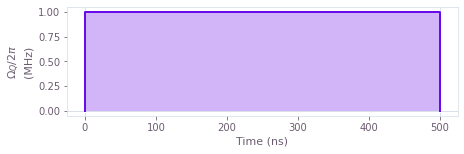

In [ ]:
omega_max = 2 * np.pi * 1e6  # Hz
standard_duration = np.pi / omega_max  # s

standard_pulse_segments = [
    qctrl.types.ComplexSegmentInput(duration=standard_duration, value=omega_max),
]

plot_segments = {
    "$\Omega_Q$": [
        {"duration": segment.duration, "value": segment.value}
        for segment in standard_pulse_segments
    ]
}

qv.plot_controls(plt.figure(), plot_segments)
plt.show()

### Noise: Magnetic field with a 1/f spectrum

The noise part of the Hamiltonian is:
\begin{align}
H_{\rm noise}(t) = \eta(t) \sigma_z / 2.
\end{align}

We treat the noisy magnetic field environment as a classical noise process $\eta(t)$ coupled to the quantum system with a noise operator $\sigma_z$. This approximate model is often reasonable for real quantum computing hardware when the decoherence time (T2) is the limiting factor, being much shorter than the relaxation time (T1) of the qubits. 

The noise process $\eta(t)$ is sampled from a noise spectral density that follows a power law: 
\begin{align}
S_{\eta}(\omega) = \frac{\omega_{\rm cutoff}^{a-1}}{\omega^a + \omega_{\rm cutoff}^a},
\end{align}
Where $\omega_{\rm cutoff}$ is the cutoff frequency and $a$ is the order of the power law. It is common for  magnetic field environments to follow 1/f power law ($a=1$) where low frequency noise dominates. 


Different physical processes will couple to the quantum computer through different noise operators. The key to getting a good simulation is to identify the noises that most significantly affect our qubits. 


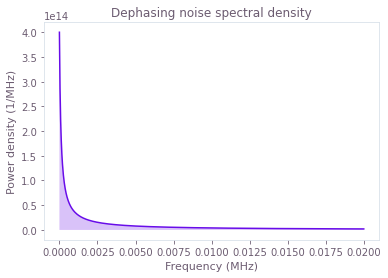

In [ ]:
def power_spectrum(frequencies, frequency_cutoff, power):
    return frequency_cutoff ** (power - 1) / (
        frequencies ** power + frequency_cutoff ** power
    )


frequencies = np.linspace(0, 2.0e4, 1000)
power_densities = 4e10 * power_spectrum(frequencies, 1.0e2, 1.0)
nsd_sampled_points = [
    {"frequency": f, "power": p, "power_uncertainty": 0.0, "weight": 0.0}
    for f, p in zip(frequencies, power_densities)
]

plot_noise_spectral_density(plt.figure(), nsd_sampled_points)

## Simulation of standard NOT Gate

Now that we have a Hamiltonian we can create a simulation. The control we have is a `shift` with $\sigma_x$ as the `operator` and $\Omega(t)$ is the `pulse`. The noise we have is an `additive noise` with $\sigma_z$ as the `operator` and  $S_\eta(\omega)$ is the `linear_piecewise_noise_spectral_density`.


In [ ]:
standard_control = qctrl.types.colored_noise_simulation.Shift(
    control=standard_pulse_segments, operator=sigma_y / 2
)

noise_drift = qctrl.types.colored_noise_simulation.Drift(
    operator=sigma_z / 2.0,
    noise=qctrl.types.colored_noise_simulation.Noise(
        power_densities=power_densities,
        frequency_step=frequencies[1],
        time_domain_sample_count=1000,
    ),
)

target = qctrl.types.TargetInput(operator=not_gate)

Now we can create a simulation of the qubit in a noisy environment.

*See also:* The [simulation user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/simulation) explains how to create multiple types of simulations.

In [ ]:
standard_point_times = np.linspace(0, standard_duration, 100)

standard_noisy_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=standard_duration,
    sample_times=standard_point_times,
    shifts=[standard_control],
    drifts=[noise_drift],
    trajectory_count=5,
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

Your task calculate_colored_noise_simulation has started.
Your task calculate_colored_noise_simulation has completed in 9s.


For comparison we can also create a simulation of a system with no noise

In [ ]:
standard_ideal_simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=standard_duration,
    sample_times=standard_point_times,
    shifts=[standard_control],
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

Your task calculate_coherent_simulation has completed in 3s.


### Noisy trajectories of the qubit state

We can display the noisy trajectories of the qubit using the coordinates of the [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere) as a representation of the state. We can see that the noisy trajectories, shown with dotted lines, take us away from the ideal simulation path, shown with the solid line. Most importantly, the final state of noisy trajectories diverges from the ideal final state. This indicates that the noise will introduce errors into our calculation and affect the outcomes of an algorithm that we want to run.

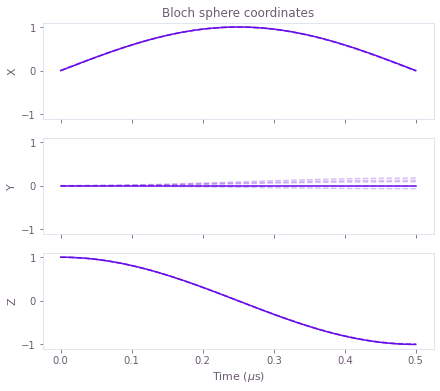

In [ ]:
plot_simulation_trajectories(
    plt.figure(),
    standard_point_times,
    standard_ideal_simulation_result.samples,
    standard_noisy_simulation_result.trajectories,
)
plt.show()

### Average gate infidelity of standard NOT gate

The results above are specific to a particular initial state. We can quantify the *average* performance of the gate under noise by looking at the average gate infidelity, defined as:

\begin{align}
\mathcal{I}_{\rm gate} = 1 - \mathbb{E}[ \rm{Tr}[ U_{\rm target}^\dagger(T) U_{\rm total}(T) ] ],
\end{align}

where $U_{k}(T)$ is the solution to $\dot{U}_{k}(t) = -i H_{k} U_{k}(t)$, $U_{\rm target}$ is the target unitary, in this case a NOT gate, and $\mathbb{E}[ \cdot ]$ is the classical stochastic average. An estimate of this number is automatically calculated when you provide a target to a stochastic simulation in BOULDER OPAL.

In [ ]:
standard_final_sample = standard_noisy_simulation_result.average_samples[-1]
print("Average gate infidelity:")
print(
    pm_format(
        standard_final_sample.average_infidelity,
        standard_final_sample.average_infidelity_uncertainty,
    )
)
print(standard_noisy_simulation_result.average_samples[-1])

Average gate infidelity:
0.0030+/-0.0013
AverageSample(time=5e-07, average_infidelity=0.0029601828152379995, average_infidelity_uncertainty=0.001325232679883104, average_density_matrix=array([[ 0.00296006+0.j        , -0.0023269 -0.03110548j],
       [-0.0023269 +0.03110548j,  0.99703994+0.j        ]]))


## Robust control design

The filter function framework can be used to design robust controls. We treat the design problem as a multi-objective optimization problem. First we assume the control field is parametrized by a set of variables $\Omega_{\rm candidate}(\underline{v},t)$. 

The first target of our optimization is to ensure that our optimized pulse performs the correct operation. To do this we need to minimize the infidelity of the control:
\begin{align}
\mathcal{I}_{\rm control} = \rm{Tr}[U_{\rm control}^\dagger(T) U_{\rm target}(T)],
\end{align}
This quantifies how close the control is to the target operation if there is no noise.

The second target of our optimization is to ensure that our optimized pulse is robust to the noise. It is common for physically relevant noise processes to be dominated by low frequency noise, in this case it simplifies the numerical calculation to minimize just the zero frequency part of the filter function. We call this the infidelity of the noise:
\begin{align}
\mathcal{I}_{\rm noise} = w^2 \left|\left| \int dt H_{\rm noise}^{\rm (control)}(t) \right|\right|_2^2,
\end{align}
where $w$ is a relative weight of the filter cost compared to the operation, a good value for additive noises is $w=1/T$.

The multi-objective optimization problem can be represented as minimizing the cost
\begin{align}
\mathcal{I}_{\rm robust}(\underline{v}) = \mathcal{I}_{\rm control}(\underline{v}) + \mathcal{I}_{\rm noise}(\underline{v}).
\end{align}


If we can find a control where $\mathcal{I}_{\rm robust}(\underline{v})$ is very close to zero, we can be sure that it will both complete the correct operation and be robust to low frequency noise.

### Optimizing a robust NOT gate

We can create a robust NOT gate using the BOULDER OPAL optimizer. The [optimization feature](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) allows the user to define an optimization with arbitrary pulse constraints. 

We are going to construct two control pulses $\Omega_I(\underline{v},t)$ and $\Omega_Q(\underline{v},t)$ which have a maximum Rabi rate $\Omega_{\rm max}$ and a bandwidth limit defined by a cutoff frequency $\Omega_{\rm cutoff}$. 

The optimizer requires that you define the quantum system as a `graph` that represents how a set of `optimization_variables` an `infidelity` you want to minimize. A series of convenience methods makes 
creating this `graph` straightforward once you have mathematically written down the total Hamiltonian ($H_{\rm total}$). Below we show how to create a `graph` for optimizing a qubit with dephasing noise. On each line, we write down what the current variable represents in the mathematical equation of the total Hamiltonian.

We restate the entire Hamiltonian below so we can easily refer to it:
\begin{align}
H_{\rm total}(t) = & H_{\rm control}(t) + H_{\rm noise}(t), \\
H_{\rm control}(t) = & \Omega_{\rm I}(t) \sigma_{x}/2 + \Omega_{\rm Q}(t) \sigma_{y}/2, \\
H_{\rm noise}(t) = & \eta(t) \sigma_z / 2.
\end{align}

In [ ]:
robust_duration = 3.0 * standard_duration
omega_cutoff = 1e7
segment_count = 100

with qctrl.create_graph() as graph:

    # Omega_I(v,t)
    pulse_i = bandwidth_limited_pwc_signal(
        name="I",
        duration=robust_duration,
        segment_count=segment_count,
        max_rabi_rate=omega_max,
        cutoff_frequency=omega_cutoff,
    )

    # Omega_Q(v,t)
    pulse_q = bandwidth_limited_pwc_signal(
        name="Q",
        duration=robust_duration,
        segment_count=segment_count,
        max_rabi_rate=omega_max,
        cutoff_frequency=omega_cutoff,
    )

    # Omega_I(t) sigma_x/2
    robust_control_i = qctrl.operations.pwc_operator(
        signal=pulse_i, operator=sigma_x / 2.0
    )

    # Omega_Q(t) sigma_y/2
    robust_control_q = qctrl.operations.pwc_operator(
        signal=pulse_q, operator=sigma_y / 2.0
    )

    # H_control = Omega_I(t) sigma_x/2 + Omega_Q(t) sigma_y/2
    control_hamiltonian = qctrl.operations.pwc_sum([robust_control_i, robust_control_q])

    # sigma_z / 2w
    noise_operator = qctrl.operations.constant_pwc_operator(
        robust_duration, sigma_z / 2.0 / robust_duration
    )

    # create U_target
    target_unitary = qctrl.operations.target(operator=not_gate)

    # create I_robust(v) = I_control(v) + I_noise(v)
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=control_hamiltonian,
        noise_operators=[
            noise_operator,
        ],
        target_operator=target_unitary,
        name="infidelity",
    )

When you run an optimization, a series of searches are performed and the pulse with the smallest cost is returned. The optimization is stochastic and therefore a different result will be returned each time, but they will always satisfy the constraints. 

A pulse that is both robust and completes the correct operation will have a cost which is very close to zero. If the cost returned does not satisfy this condition, you may need to reduce your constraints. Increasing the total duration and/or the number of segments will often help.

In [ ]:
optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=["infidelity", "I", "Q"],
    graph=graph,
)

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 8s.


In [ ]:
optimization_result

Result(cost=1.4300662564383862e-09, output={'I': [{'value': 242653.6137201316, 'duration': 1.5000000000000002e-08}, {'value': 188354.91479048404, 'duration': 1.5000000000000002e-08}, {'value': 122887.06698561733, 'duration': 1.5000000000000002e-08}, {'value': 46448.87315650932, 'duration': 1.5000000000000002e-08}, {'value': -40582.74864624049, 'duration': 1.5000000000000002e-08}, {'value': -137654.43142013473, 'duration': 1.5000000000000002e-08}, {'value': -244041.19504581013, 'duration': 1.5000000000000002e-08}, {'value': -358854.4216487444, 'duration': 1.5000000000000002e-08}, {'value': -481052.8814210633, 'duration': 1.5000000000000002e-08}, {'value': -609456.6616958072, 'duration': 1.5000000000000002e-08}, {'value': -742763.7959121672, 'duration': 1.5000000000000002e-08}, {'value': -879569.3360421287, 'duration': 1.5000000000000002e-08}, {'value': -1018386.5631151496, 'duration': 1.5000000000000002e-08}, {'value': -1157669.9866593378, 'duration': 1.5000000000000002e-08}, {'value': 

In [ ]:
print("Best cost:")
print(optimization_result.cost)

Best cost:
1.4300662564383862e-09


Once you have completed an optimization with a good cost you can export the segments of the pulse to your device.


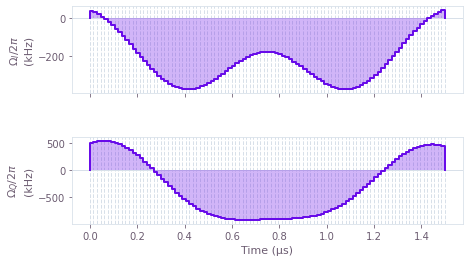

In [ ]:
qv.plot_controls(
    plt.figure(),
    {
        "$\Omega_I$": optimization_result.output["I"],
        "$\Omega_Q$": optimization_result.output["Q"],
    },
)
plt.show()

## Sending the pulse to the cloud to realize the NOT gate

In [ ]:
Ivals, Qvals = optimization_result.output["I"], optimization_result.output["Q"]

In [ ]:
Qvals

[{'duration': 1.5000000000000002e-08, 'value': 3228153.996921337},
 {'duration': 1.5000000000000002e-08, 'value': 3331626.1738166204},
 {'duration': 1.5000000000000002e-08, 'value': 3400993.995268936},
 {'duration': 1.5000000000000002e-08, 'value': 3434378.57314747},
 {'duration': 1.5000000000000002e-08, 'value': 3430377.9517383296},
 {'duration': 1.5000000000000002e-08, 'value': 3388090.1555592334},
 {'duration': 1.5000000000000002e-08, 'value': 3307127.77314859},
 {'duration': 1.5000000000000002e-08, 'value': 3187623.8151343106},
 {'duration': 1.5000000000000002e-08, 'value': 3030228.7474707053},
 {'duration': 1.5000000000000002e-08, 'value': 2836098.7654624777},
 {'duration': 1.5000000000000002e-08, 'value': 2606875.537870365},
 {'duration': 1.5000000000000002e-08, 'value': 2344657.809824857},
 {'duration': 1.5000000000000002e-08, 'value': 2051965.4053483258},
 {'duration': 1.5000000000000002e-08, 'value': 1731696.312027053},
 {'duration': 1.5000000000000002e-08, 'value': 1387077.65

In [ ]:
control_count = 1
segment_count = len(Ivals)
duration = Ivals[0]['duration']*1e9
shot_count = 512

In [ ]:
values = []
R, C = [], []
for RE, COM in zip(Ivals, Qvals):
  r = RE['value']
  c = COM['value']
  R.append(r)
  C.append(c)

# R = (np.array(R) - np.mean(R))/ np.std(R)
# C = (np.array(C) - np.mean(C))/ np.std(C)

for r, c in zip(R, C):
  values.append(r + 1j * c)
# values = np.array(values)
# values = (values - np.mean(values)) / np.std(values)

In [ ]:
norm = np.linalg.norm(values)
values = values/norm

In [ ]:
controls = []
controls.append({"duration":duration, "values": np.array(values)})

In [ ]:
controls

[{'duration': 15.000000000000002,
  'values': array([ 0.0056953 +0.07576767j,  0.00442086+0.07819626j,
          0.00288427+0.07982438j,  0.0010902 +0.08060795j,
         -0.00095251+0.08051405j, -0.00323087+0.07952152j,
         -0.00572787+0.07762126j, -0.00842264+0.07481639j,
         -0.01129074+0.07112219j, -0.0143045 +0.06656579j,
         -0.01743333+0.06118571j, -0.02064428+0.05503122j,
         -0.02390245+0.04816147j, -0.02717155+0.04064447j,
         -0.03041452+0.03255596j, -0.03359406+0.02397814j,
         -0.03667327+0.01499829j, -0.03961628+0.00570733j,
         -0.0423888 -0.00380166j, -0.04495874-0.01343496j,
         -0.04729678-0.02309969j, -0.04937682-0.03270526j,
         -0.05117649-0.0421648j , -0.05267753-0.05139639j,
         -0.05386614-0.06032431j, -0.05473323-0.06888008j,
         -0.05527461-0.07700331j, -0.05549107-0.08464252j,
         -0.05538844-0.09175558j, -0.05497746-0.09831018j,
         -0.05427367-0.1042839j , -0.05329716-0.10966425j,
         -0.

In [ ]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

Your task calculate_qchack_measurements has completed in 3s.


In [ ]:
measurements = experiment_results.measurements
for measurement_counts in enumerate(measurements):
    print("control: {measurement_counts}")

control 1: (0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])


In [ ]:
for measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control 1: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control 1: P(|0>) = 0.00, P(|1>) = 0.00, P(|2>) = 0.00
